# Document AI | Fine-tune LiLT on DocLayNet base in any language at line level (chunk of 384 tokens with overlap)

- Credit: 
  - notebook created from the notebook [Fine_tune_LiLT_on_a_custom_dataset_in_any_language.ipynb](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LiLT/Fine_tune_LiLT_on_a_custom_dataset%2C_in_any_language.ipynb) of [Niels ROGGE](https://github.com/NielsRogge)
  -  dataset from IBM Research ([DocLayNet](https://github.com/DS4SD/DocLayNet))
- Author of this notebook: [Pierre GUILLOU](https://www.linkedin.com/in/pierreguillou/)
- Blog post: [Document AI | Document Understanding model at line level with LiLT and DocLayNet dataset]()
- Other notebook: [Document AI | Inference at line level with a Document Understanding model (LiLT fine-tuned on DocLayNet dataset)](https://github.com/piegu/language-models/blob/master/inference_on_LiLT_model_finetuned_on_DocLayNet_base_in_any_language_at_levellines_ml384.ipynb)
- Date: 02/10/2023

## Overview

### LiLT

[LiLT](https://arxiv.org/abs/2202.13669) (Language-Independent Layout Transformer) is a Document Understanding model that uses both layout and text in order to detect labels of bounding boxes. It relies on an external OCR engine like [PyTesseract](https://github.com/madmaze/pytesseract#python-tesseract) to get words and bboxes from the document image. 

Sources:

- [Fine_tuning_LayoutLMForTokenClassification_on_FUNSD.ipynb](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLM/Fine_tuning_LayoutLMForTokenClassification_on_FUNSD.ipynb)
- https://www.kaggle.com/jpmiller/layoutlm-starter
- https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0 

### DocLayNet

#### DocLayNet dataset

[DocLayNet dataset](https://github.com/DS4SD/DocLayNet) (IBM) provides page-by-page layout segmentation ground-truth using bounding-boxes for 11 distinct class labels on 80863 unique pages from 6 document categories. 

Until today, the dataset can be downloaded through direct links or as a dataset from Hugging Face datasets:
- direct links: [doclaynet_core.zip](https://codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud/dax-doclaynet/1.0.0/DocLayNet_core.zip) (28 GiB), [doclaynet_extra.zip](https://codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud/dax-doclaynet/1.0.0/DocLayNet_extra.zip) (7.5 GiB)
- Hugging Face dataset library: [dataset DocLayNet](https://huggingface.co/datasets/ds4sd/DocLayNet)

Paper: [DocLayNet: A Large Human-Annotated Dataset for Document-Layout Analysis](https://arxiv.org/abs/2206.01062) (06/02/2022)

#### Processing into a format facilitating its use by HF notebooks

These 2 options require the downloading of all the data (approximately 30GBi), which requires downloading time (about 45 mn in Google Colab) and a large space on the hard disk. These could limit experimentation for people with low resources.

Moreover, even when using the download via HF datasets library, it is necessary to download the EXTRA zip separately ([doclaynet_extra.zip](https://codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud/dax-doclaynet/1.0.0/DocLayNet_extra.zip), 7.5 GiB) to associate the annotated bounding boxes with the text extracted by OCR from the PDFs. This operation also requires additional code because the boundings boxes of the texts do not necessarily correspond to those annotated (a calculation of the percentage of area in common between the boundings boxes annotated and those of the texts makes it possible to make a comparison between them).

At last, in order to use Hugging Face notebooks on fine-tuning layout models like LayoutLMv3 or LiLT, DocLayNet data must be processed in a proper format.

For all these reasons, I decided to process the DocLayNet dataset:
- into 3 datasets of different sizes:
  - [DocLayNet small](https://huggingface.co/datasets/pierreguillou/DocLayNet-small) (about 1% of DocLayNet) < 1.000k document images (691 train, 64 val, 49 test)
  - [DocLayNet base](https://huggingface.co/datasets/pierreguillou/DocLayNet-base) (about 10% of DocLayNet) < 10.000k document images (6910 train, 648 val, 499 test)
  - [DocLayNet large](https://huggingface.co/datasets/pierreguillou/DocLayNet-large) (about 100% of DocLayNet) < 100.000k document images (69.103 train, 6.480 val, 4.994 test)
- with associated texts and PDFs (base64 format),
- and in a format facilitating their use by HF notebooks.

*Note: the layout HF notebooks will greatly help participants of the IBM [ICDAR 2023 Competition on Robust Layout Segmentation in Corporate Documents](https://ds4sd.github.io/icdar23-doclaynet/)!*

#### About PDFs languages

Citation of the page 3 of the [DocLayNet paper](https://arxiv.org/abs/2206.01062): 
"We did not control the document selection with regard to language. **The vast majority of documents contained in DocLayNet (close to 95%) are published in English language.** However, **DocLayNet also contains a number of documents in other languages such as German (2.5%), French (1.0%) and Japanese (1.0%)**. While the document language has negligible impact on the performance of computer vision methods such as object detection and segmentation models, it might prove challenging for layout analysis methods which exploit textual features."

#### About PDFs categories distribution

Citation of the page 3 of the [DocLayNet paper](https://arxiv.org/abs/2206.01062): 
"The pages in DocLayNet can be grouped into **six distinct categories**, namely **Financial Reports, Manuals, Scientific Articles, Laws & Regulations, Patents and Government Tenders**. Each document category was sourced from various repositories. For example, Financial Reports contain both free-style format annual reports which expose company-specific, artistic layouts as well as the more formal SEC filings. The two largest categories (Financial Reports and Manuals) contain a large amount of free-style layouts in order to obtain maximum variability. In the other four categories, we boosted the variability by mixing documents from independent providers, such as different government websites or publishers. In Figure 2, we show the document categories contained in DocLayNet with their respective sizes."

![DocLayNet PDFs categories distribution (source: DocLayNet paper)](https://huggingface.co/datasets/pierreguillou/DocLayNet-base/resolve/main/DocLayNet_PDFs_categories_distribution.png)

#### DocLayNet Labels

The DocLayNet labels have the following meaning (source: [IBM DocLayNet Labeling Guide](https://raw.githubusercontent.com/DS4SD/DocLayNet/main/assets/DocLayNet_Labeling_Guide_Public.pdf))
- Text: Regular paragraphs.
- Picture: A graphic or photograph.
- Caption: Special text outside a picture or table that introduces this picture or table.
- Section-header: Any kind of heading in the text, except overall document title.
- Footnote: Typically small text at the bottom of a page, with a number or symbol that is referred to in the text above.
- Formula: Mathematical equation on its own line. 

Further labels not shown in the example above:
- Table: Material arranged in a grid alignment with rows and columns, often with separator lines.
- List-item: One element of a list, in a hanging shape, i.e., from the second line onwards the paragraph is indented more than the first line.
- Page-header: Repeating elements like page number at the top, outside of the normal text flow.
- Page-footer: Repeating elements like page number at the bottom, outside of the normal text flow.
- Title: 1 Overall title of a document, (almost) exclusively on the first page and
- typically appearing in large font.
- None: Initial state of each cell/element. Only keep this if the element is not a text or picture or anything else of value. For instance, a smear or an invisible/empty cell should remain “None

In [ ]:
!nvidia-smi

Thu Feb  9 15:35:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    19W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set-up environment

In [ ]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Libraries

In [ ]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 109.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.8 MB/s eta 0:00:00


In [ ]:
!pip install -q evaluate #seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 441.9 kB/s eta 0:00:00


In [ ]:
# this will allow the notebook to reload/refresh automatically within the runtime
%reload_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
from operator import itemgetter
import collections
import pandas as pd

import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

font = ImageFont.load_default()

import cv2
# In Colab, use cv2_imshow instead of cv2.imshow
from google.colab.patches import cv2_imshow # Colab

from ipywidgets import widgets
from IPython.display import display, HTML

from datasets import  concatenate_datasets

### Key parameters

In [ ]:
# categories colors
label2color = {
    'Caption': 'brown',
    'Footnote': 'orange',
    'Formula': 'gray',
    'List-item': 'yellow',
    'Page-footer': 'red',
    'Page-header': 'red',
    'Picture': 'violet',
    'Section-header': 'orange',
    'Table': 'green',
    'Text': 'blue',
    'Title': 'pink'
    }

# # https://www.rapidtables.com/web/color/RGB_Color.html
# label2color_rgb = {
#     'Caption': (128,0,0), # brown
#     'Footnote': (255,140,0), # orange
#     'Formula': (128,128,128), # gray
#     'List-item': (255,255,0), # yellow
#     'Page-footer': (255,0,0), # red
#     'Page-header': (255,0,0), # red
#     'Picture': (255,0,255), # violet
#     'Section-header': (255,140,0), # orange
#     'Table': (0,255,0), # green
#     'Text': (0,0,255), # blue
#     'Title': (255,20,147) # pink
#     }

domains = ["Financial Reports", "Manuals", "Scientific Articles", "Laws & Regulations", "Patents", "Government Tenders"]
domain_names = [domain_name.lower().replace(" ", "_").replace("&", "and") for domain_name in domains]

# bounding boxes start and end of a sequence
cls_box = [0, 0, 0, 0]
sep_box = cls_box

# DocLayNet dataset
# dataset_name = "pierreguillou/DocLayNet-small"
dataset_name = "pierreguillou/DocLayNet-base"
dataset_name_suffix = dataset_name.replace("pierreguillou/DocLayNet-", "")

# parameters for tokenization and overlap
max_length = 384 # The maximum length of a feature (sequence)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

# parameters de TrainingArguments
batch_size=8 # WARNING: change this value according to your GPU RAM
num_train_epochs=5
learning_rate=5e-5
per_device_train_batch_size=batch_size
per_device_eval_batch_size=batch_size*2
gradient_accumulation_steps=1
evaluation_strategy="steps"
eval_steps=300
save_steps=300 # eval_steps
save_total_limit=2
load_best_model_at_end=True
metric_for_best_model="f1"
report_to="tensorboard"
fp16=True
push_to_hub=True # we'd like to push our model to the hub during training
hub_private_repo=True
hub_strategy="all_checkpoints"

# model name in HF
version = 2 # version number

output_dir = "DocLayNet/lilt-xlm-roberta-base-finetuned-" + dataset_name.replace("pierreguillou/", "") + "_lines_ml" + str(max_length) + "-v" + str(version)
hub_model_id = "pierreguillou/lilt-xlm-roberta-base-finetuned-" + dataset_name.replace("pierreguillou/", "") + "_lines_ml" + str(max_length) + "-v" + str(version)

### Functions

#### General

In [ ]:
# it is important that each bounding box should be in (upper left, lower right) format.
# source: https://github.com/NielsRogge/Transformers-Tutorials/issues/129
def upperleft_to_lowerright(bbox):
    x0, y0, x1, y1 = tuple(bbox)
    if bbox[2] < bbox[0]:
        x0 = bbox[2]
        x1 = bbox[0] 
    if bbox[3] < bbox[1]:
        y0 = bbox[3]
        y1 = bbox[1] 
    return [x0, y0, x1, y1]
  
# convert boundings boxes (left, top, width, height) format to (left, top, left+widght, top+height) format. 
def convert_box(bbox):
    x, y, w, h = tuple(bbox) # the row comes in (left, top, width, height) format
    return [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box 

# LiLT model gets 1000x10000 pixels images
def normalize_box(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),
    ]

# LiLT model gets 1000x10000 pixels images
def denormalize_box(bbox, width, height):
    return [
        int(width * (bbox[0] / 1000)),
        int(height * (bbox[1] / 1000)),
        int(width* (bbox[2] / 1000)),
        int(height * (bbox[3] / 1000)),
    ]

# get back original size
def original_box(box, original_width, original_height, coco_width, coco_height):
    return [
        int(original_width * (box[0] / coco_width)),
        int(original_height * (box[1] / coco_height)),
        int(original_width * (box[2] / coco_width)),
        int(original_height* (box[3] / coco_height)),
    ]

def get_blocks(bboxes_block, categories, texts):

 # get list of unique block boxes
    bbox_block_dict, bboxes_block_list, bbox_block_prec = dict(), list(), list()
    for count_block, bbox_block in enumerate(bboxes_block):
        if bbox_block != bbox_block_prec:
            bbox_block_indexes = [i for i, bbox in enumerate(bboxes_block) if bbox == bbox_block]
            bbox_block_dict[count_block] = bbox_block_indexes
            bboxes_block_list.append(bbox_block)
        bbox_block_prec = bbox_block

    # get list of categories and texts by unique block boxes
    category_block_list, text_block_list = list(), list()
    for bbox_block in bboxes_block_list:
        count_block = bboxes_block.index(bbox_block)
        bbox_block_indexes = bbox_block_dict[count_block]
        category_block = np.array(categories, dtype=object)[bbox_block_indexes].tolist()[0]
        category_block_list.append(category_block)
        text_block = np.array(texts, dtype=object)[bbox_block_indexes].tolist()
        text_block = [text.replace("\n","").strip() for text in text_block]
        if id2label[category_block] == "Text" or id2label[category_block] == "Caption" or id2label[category_block] == "Footnote":
            text_block = ' '.join(text_block)
        else:
            text_block = '\n'.join(text_block)
        text_block_list.append(text_block)

    return bboxes_block_list, category_block_list, text_block_list

# function to sort bounding boxes
def get_sorted_boxes(bboxes):

    # sort by y from page top to bottom 
    sorted_bboxes = sorted(bboxes, key=itemgetter(1), reverse=False)
    y_list = [bbox[1] for bbox in sorted_bboxes]

    # sort by x from page left to right when boxes with same y
    if len(list(set(y_list))) != len(y_list):
        y_list_duplicates_indexes = dict()
        y_list_duplicates = [item for item, count in collections.Counter(y_list).items() if count > 1]
        for item in y_list_duplicates:
            y_list_duplicates_indexes[item] = [i for i, e in enumerate(y_list) if e == item]
            bbox_list_y_duplicates = sorted(np.array(sorted_bboxes, dtype=object)[y_list_duplicates_indexes[item]].tolist(), key=itemgetter(0), reverse=False)
            np_array_bboxes = np.array(sorted_bboxes)
            np_array_bboxes[y_list_duplicates_indexes[item]] = np.array(bbox_list_y_duplicates)
            sorted_bboxes = np_array_bboxes.tolist()

    return sorted_bboxes

# sort data from y = 0 to end of page (and after, x=0 to end of page when necessary)
def sort_data(bboxes, categories, texts):

    sorted_bboxes = get_sorted_boxes(bboxes)
    sorted_bboxes_indexes = [bboxes.index(bbox) for bbox in sorted_bboxes]
    sorted_categories = np.array(categories, dtype=object)[sorted_bboxes_indexes].tolist()
    sorted_texts = np.array(texts, dtype=object)[sorted_bboxes_indexes].tolist()

    return sorted_bboxes, sorted_categories, sorted_texts

#### Dataset

In [ ]:
# get PDF image and its data
def generate_annotated_image(index_image=None, split="all"):

    # get dataset
    example = dataset

    # get split
    if split == "all":
        example = concatenate_datasets([example["train"], example["validation"], example["test"]])
    else:
        example = example[split]

    # get random image & PDF data
    if index_image == None: index_image = random.randint(0, len(example)-1)
    example = example[index_image]
    image = example["image"] # original image
    coco_width, coco_height = example["coco_width"], example["coco_height"]
    original_width, original_height = example["original_width"], example["original_height"]
    original_filename = example["original_filename"]
    page_no = example["page_no"]
    num_pages = example["num_pages"]

    # resize image to original
    image = image.resize((original_width, original_height))

    # get corresponding annotations
    texts = example["texts"]
    bboxes_block = example["bboxes_block"]
    bboxes_line = example["bboxes_line"]
    categories = example["categories"]
    domain = example["doc_category"]

    # get domain name
    index_domain = domain_names.index(domain)
    domain = domains[index_domain]

    # convert boxes to original
    original_bboxes_block = [original_box(convert_box(box), original_width, original_height, coco_width, coco_height) for box in bboxes_block]
    original_bboxes_line = [original_box(convert_box(box), original_width, original_height, coco_width, coco_height) for box in bboxes_line]

    ##### block boxes #####

    # get unique blocks and its data
    bboxes_blocks_list, category_block_list, text_block_list = get_blocks(original_bboxes_block, categories, texts)

    # sort data from y = 0 to end of page (and after, x=0 to end of page when necessary)
    sorted_original_bboxes_block_list, sorted_category_block_list, sorted_text_block_list = sort_data(bboxes_blocks_list, category_block_list, text_block_list)

    ##### line boxes ####

    # sort data from y = 0 to end of page (and after, x=0 to end of page when necessary)
    sorted_original_bboxes_line_list, sorted_category_line_list, sorted_text_line_list = sort_data(original_bboxes_line, categories, texts)

    # group paragraphs and lines outputs
    sorted_original_bboxes = [sorted_original_bboxes_block_list, sorted_original_bboxes_line_list]
    sorted_categories = [sorted_category_block_list, sorted_category_line_list]
    sorted_texts = [sorted_text_block_list, sorted_text_line_list]

    # get annotated boudings boxes on images
    images = [image.copy(), image.copy()]

    imgs, df_paragraphs, df_lines = dict(), pd.DataFrame(), pd.DataFrame()
    for i, img in enumerate(images):

        img = img.convert('RGB') # Convert to RGB
        draw = ImageDraw.Draw(img)
        
        for box, label_idx, text in zip(sorted_original_bboxes[i], sorted_categories[i], sorted_texts[i]):
            label = id2label[label_idx]
            color = label2color[label]
            draw.rectangle(box, outline=color)
            text = text.encode('latin-1', 'replace').decode('latin-1') # https://stackoverflow.com/questions/56761449/unicodeencodeerror-latin-1-codec-cant-encode-character-u2013-writing-to
            draw.text((box[0] + 10, box[1] - 10), text=label, fill=color, font=font)

        if i == 0: 
            imgs["paragraphs"] = img
        
            df_paragraphs["paragraphs"] = list(range(len(sorted_original_bboxes_block_list)))
            df_paragraphs["categories"] = [id2label[label_idx] for label_idx in sorted_category_block_list]
            df_paragraphs["texts"] = sorted_text_block_list
            df_paragraphs["bounding boxes"] = [str(bbox) for bbox in sorted_original_bboxes_block_list]

        else: 
            imgs["lines"] = img

            df_lines["lines"] = list(range(len(sorted_original_bboxes_line_list)))
            df_lines["categories"] = [id2label[label_idx] for label_idx in sorted_category_line_list]
            df_lines["texts"] = sorted_text_line_list
            df_lines["bounding boxes"] = [str(bbox) for bbox in sorted_original_bboxes_line_list]

    return imgs, original_filename, page_no, num_pages, domain, df_paragraphs, df_lines

In [ ]:
# display PDF image and its data
def display_pdf_blocks_lines(index_image=None, split="all"):

    # get image and image data
    images, original_filename, page_no, num_pages, domain, df_paragraphs, df_lines = generate_annotated_image(index_image=index_image, split=split)

    print(f"PDF: {original_filename} (page: {page_no+1} / {num_pages}; domain: {domain})\n")

    # left widget
    style1 = {'overflow': 'scroll' ,'white-space': 'nowrap', 'width':'50%'}
    output1 = widgets.Output(description = "PDF image with bounding boxes of paragraphs", style=style1)
    with output1:
    
        # display image
        print(">> PDF image with bounding boxes of paragraphs\n")
        
        open_cv_image = np.array(images["paragraphs"]) # PIL to cv2
        # Convert RGB to BGR 
        open_cv_image = open_cv_image[:, :, ::-1].copy() 

        # cv2.imshow('',open_cv_image) # lambda
        cv2_imshow(open_cv_image) # Colab
        cv2.waitKey(0)

        # display DataFrame
        print("\n>> Paragraphs dataframe\n")
        display(df_paragraphs)

    # right widget
    style2 = style1
    output2 = widgets.Output(description = "PDF image with bounding boxes of lines", style=style2)
    with output2:
    
        # display image
        print(">> PDF image with bounding boxes of lines\n")
  
        open_cv_image = np.array(images["lines"]) # PIL to cv2
        # Convert RGB to BGR 
        open_cv_image = open_cv_image[:, :, ::-1].copy() 

        # cv2.imshow('',open_cv_image) # lambda
        cv2_imshow(open_cv_image) # Colab
        cv2.waitKey(0)

        # display DataFrame
        print("\n>> Lines dataframe\n")
        display(df_lines)

    ## Side by side thanks to HBox widgets
    sidebyside = widgets.HBox([output1,output2])
    ## Finally, show.
    display(sidebyside)

#### Encoded dataset

In [ ]:
# creation of encoded dataset
def prepare_features(example, cls_box = cls_box, sep_box = sep_box):

    input_ids_list, attention_mask_list, bb_list, ll_list, page_hash_list = list(), list(), list(), list(), list()

    # get batch
    batch_page_hash = example["page_hash"] 
    batch_bboxes_line = example["bboxes_line"]
    batch_categories = example["categories"]
    batch_texts = example["texts"] 
    # batch_original_width, batch_original_height = example["original_width"] , example["original_height"] 
    batch_coco_width, batch_coco_height = example["coco_width"] , example["coco_height"] 

    # add a dimension if not a batch but only one image
    if not isinstance(batch_page_hash, list): 
        batch_page_hash = [batch_page_hash]
        batch_bboxes_line = [batch_bboxes_line]
        batch_categories = [batch_categories]
        batch_texts = [batch_texts]
        # batch_original_width, batch_original_height = [batch_original_width], [batch_original_height] 
        batch_coco_width, batch_coco_height = [batch_coco_width], [batch_coco_height] 
          
    # process all images of the batch
    for num_batch, (page_hash, boxes, labels, texts, coco_width, coco_height) in enumerate(zip(batch_page_hash, batch_bboxes_line, batch_categories, batch_texts, batch_coco_width, batch_coco_height)):
        tokens_list = []
        bboxes_list = []
        labels_list = []

        # add a dimension if only on image
        if not isinstance(texts, list):
            texts, boxes, labels = [texts], [boxes], [labels]

        # convert boxes to original
        # Check the upperleft_to_lowerright
        # normalize
        normalize_bboxes_line = [normalize_box(upperleft_to_lowerright(convert_box(box)), coco_width, coco_height) for box in boxes]

        # sort boxes with categorizations and texts
        # we want sorted lists from top to bottom of the image
        boxes, labels, texts = sort_data(normalize_bboxes_line, labels, texts)

        count = 0
        for box, label, text in zip(boxes, labels, texts):
            tokens = tokenizer.tokenize(text)
            num_tokens = len(tokens) # get number of tokens
            tokens_list.extend(tokens)

            bboxes_list.extend([box] * num_tokens) # number of boxes must be the same as the number of tokens
            labels_list.extend([label] + ([-100] * (num_tokens - 1))) # number of labels id must be the same as the number of tokens

        # use of return_overflowing_tokens=True / stride=doc_stride
        # to get parts of image with overlap
        # source: https://huggingface.co/course/chapter6/3b?fw=tf#handling-long-contexts
        encodings = tokenizer(" ".join(texts), 
                            truncation=True,
                            padding="max_length", 
                            max_length=max_length, 
                            stride=doc_stride, 
                            return_overflowing_tokens=True, 
                            return_offsets_mapping=True
                            )

        _ = encodings.pop("overflow_to_sample_mapping")
        offset_mapping = encodings.pop("offset_mapping")

        # Let's label those examples and get their boxes   
        sequence_length_prev = 0   
        for i, offsets in enumerate(offset_mapping):
            # truncate tokens, boxes and labels based on length of chunk - 2 (special tokens <s> and </s>)
            sequence_length = len(encodings.input_ids[i]) - 2
            if i == 0: start = 0
            else: start += sequence_length_prev - doc_stride
            end = start + sequence_length
            sequence_length_prev = sequence_length

            # get tokens, boxes and labels of this image chunk
            bb = [cls_box] + bboxes_list[start:end] + [sep_box]

            # check if the start truncation is on label -100
            ll = labels_list[start:end]
            flag = True
            label_to_use = -100
            count = 0
            ll_ori = ll.copy()
            while flag:
                if len(ll) > 0:
                    if ll[0] != -100 and count == 0:
                        flag = False
                    elif ll[0] == -100 and count == 0:
                        ll = ll[1:]
                        count += 1
                    elif ll[0] != -100 and count > 0:
                        label_to_use = ll[0]
                        flag = False
                    elif ll[0] == -100 and count > 0:
                        ll = ll[1:]
                        count += 1
                else:
                    flag = False

            if label_to_use != -100:
                ll = [label_to_use]*count + ll_ori[count:]
            else:
                ll = ll_ori

            # check if the end truncation is on label -100
            flag = True
            label_to_use = -100
            count = 0
            ll_ori = ll.copy()
            while flag:
                if len(ll) > 0:
                    if ll[-1] != -100 and count == 0:
                        flag = False
                    elif ll[-1] == -100 and count == 0:
                        ll = ll[:-1]
                        count += 1
                    elif ll[-1] != -100 and count > 0:
                        label_to_use = ll[-1]
                        flag = False
                    elif ll[-1] == -100 and count > 0:
                        ll = ll[:-1]
                        count += 1
                else:
                    flag = False

            if label_to_use != -100:
                ll = ll_ori[:-count] + [label_to_use]*count
            else:
                ll = ll_ori

            # get labels for this chunck
            ll = [-100] + ll + [-100]

            # as the last chunk can have a length < max_length
            # we must to add [tokenizer.pad_token] (tokens), [sep_box] (boxes) and [-100] (labels)
            if len(bb) < max_length:
                bb = bb + [sep_box] * (max_length - len(bb))
                ll = ll + [-100] * (max_length - len(ll))

            # append results
            input_ids_list.append(encodings["input_ids"][i])
            attention_mask_list.append(encodings["attention_mask"][i])
            bb_list.append(bb)
            ll_list.append(ll)
            page_hash_list.append(page_hash)
        
    return {
      "input_ids": input_ids_list,
      "attention_mask": attention_mask_list,
      "normalized_bboxes": bb_list,
      "labels": ll_list,
      "page_hash": page_hash_list,
      }

In [ ]:
# get data of encoded chunk
def get_encoded_chunk(index_chunk=None, split="all"):

    # get datasets
    example = dataset
    encoded_example = encoded_dataset

    # get split
    if split == "all":
        example = concatenate_datasets([example["train"], example["validation"], example["test"]])
        encoded_example = concatenate_datasets([encoded_example["train"], encoded_example["validation"], encoded_example["test"]])
    else:
        example = example[split]
        encoded_example = encoded_example[split]

    # get randomly a document in dataset
    if index_chunk == None: index_chunk = random.randint(0, len(encoded_example)-1)
    encoded_example = encoded_example[index_chunk]
    encoded_page_hash = encoded_example["page_hash"]

    # get the image
    example = example.filter(lambda example: example["page_hash"] == encoded_page_hash)[0]
    image = example["image"] # original image
    coco_width, coco_height = example["coco_width"], example["coco_height"]
    # original_width, original_height = example["original_width"], example["original_height"]
    original_filename = example["original_filename"]
    page_no = example["page_no"]
    num_pages = example["num_pages"]
    domain = example["doc_category"]

    # get domain name
    index_domain = domain_names.index(domain)
    domain = domains[index_domain]

    # resize image to original
    # image = image.resize((original_width, original_height))

    # get boxes, texts, categories
    bboxes, labels_id, input_ids  = encoded_example["normalized_bboxes"][1:-1], encoded_example["labels"][1:-1], encoded_example["input_ids"][1:-1]
    bboxes = [denormalize_box(bbox, coco_width, coco_height) for bbox in bboxes]
    num_tokens = len(input_ids) + 2

    # get unique bboxes and corresponding labels
    bboxes_list, labels_list, input_ids_list = list(), list(), list()
    input_ids_dict = dict()
    bbox_prev = [-100, -100, -100, -100]
    for i, (bbox, label_id, input_id) in enumerate(zip(bboxes, labels_id, input_ids)):
        if bbox != bbox_prev:
            bboxes_list.append(bbox)
            input_ids_dict[str(bbox)] = [input_id]
            labels_list.append(label_id)
            label_id_prev = label_id
        else:
            input_ids_dict[str(bbox)].append(input_id)
    
        # start_indexes_list.append(i)
        bbox_prev = bbox
  
    # do not keep "</s><pad><pad>..."
    if input_ids_dict[str(bboxes_list[-1])][0] == (tokenizer.convert_tokens_to_ids('</s>')):
        del input_ids_dict[str(bboxes_list[-1])]
        bboxes_list = bboxes_list[:-1]
        labels_list = labels_list[:-1]

    # get texts by line
    input_ids_list = input_ids_dict.values()
    texts_list = [tokenizer.decode(input_ids) for input_ids in input_ids_list]
  
    # display DataFrame
    df = pd.DataFrame({"texts": texts_list, "input_ids": input_ids_list, "labels_ids": labels_list, "bboxes": bboxes_list})

    return image, original_filename, page_no, num_pages, domain, df, num_tokens

In [ ]:
# display chunk of PDF image and its data
def display_chunk_lines(index_chunk=None, split="all"):

    # get image and image data
    image, original_filename, page_no, num_pages, domain, df, num_tokens = get_encoded_chunk(index_chunk=index_chunk, split=split)
    image = image.convert('RGB') # Convert to RGB

    # get data from dataframe
    input_ids = df["input_ids"]
    texts = df["texts"]
    labels_ids = df["labels_ids"]
    bboxes = df["bboxes"]

    print(f'Chunk ({num_tokens} tokens) of the PDF "{original_filename}" (page: {page_no+1} / {num_pages}; domain: {domain})\n')

    # display image with annotated bounding boxes
    print(">> PDF image with bounding boxes of lines\n")
    draw = ImageDraw.Draw(image)
            
    labels = list()
    for box, label_idx, text in zip(bboxes, labels_ids, texts):
        label = id2label[label_idx]
        labels.append(label)
        color = label2color[label]
        draw.rectangle(box, outline=color)
        text = text.encode('latin-1', 'replace').decode('latin-1') # https://stackoverflow.com/questions/56761449/unicodeencodeerror-latin-1-codec-cant-encode-character-u2013-writing-to
        draw.text((box[0] + 10, box[1] - 10), text=label, fill=color, font=font)

    open_cv_image = np.array(image) # PIL to cv2
    # Convert RGB to BGR 
    open_cv_image = open_cv_image[:, :, ::-1].copy() 

    # cv2.imshow('',open_cv_image) # lambda
    cv2_imshow(open_cv_image) # Colab
    cv2.waitKey(0)

    # display image dataframe
    print("\n>> Dataframe of annotated lines\n")
    df["labels"] = labels
    cols = ["texts", "labels",	"bboxes"]
    df = df[cols]
    display(df)

## HF login

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

## Download DocLayNet

### Download

In [ ]:
local_dataset_name = "/content/drive/MyDrive/DocLayNet/datasets/" + dataset_name.replace("pierreguillou/DocLayNet-", "")

In [ ]:
from datasets import load_dataset
dataset = load_dataset(dataset_name)

# save locally
dataset.save_to_disk(local_dataset_name)

In [ ]:
# load
from datasets import load_from_disk
dataset = load_from_disk(local_dataset_name)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'texts', 'bboxes_block', 'bboxes_line', 'categories', 'image', 'page_hash', 'original_filename', 'page_no', 'num_pages', 'original_width', 'original_height', 'coco_width', 'coco_height', 'collection', 'doc_category'],
        num_rows: 6910
    })
    validation: Dataset({
        features: ['id', 'texts', 'bboxes_block', 'bboxes_line', 'categories', 'image', 'page_hash', 'original_filename', 'page_no', 'num_pages', 'original_width', 'original_height', 'coco_width', 'coco_height', 'collection', 'doc_category'],
        num_rows: 648
    })
    test: Dataset({
        features: ['id', 'texts', 'bboxes_block', 'bboxes_line', 'categories', 'image', 'page_hash', 'original_filename', 'page_no', 'num_pages', 'original_width', 'original_height', 'coco_width', 'coco_height', 'collection', 'doc_category'],
        num_rows: 499
    })
})

In [ ]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'texts': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes_block': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'bboxes_line': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'categories': Sequence(feature=ClassLabel(names=['Caption', 'Footnote', 'Formula', 'List-item', 'Page-footer', 'Page-header', 'Picture', 'Section-header', 'Table', 'Text', 'Title'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None),
 'page_hash': Value(dtype='string', id=None),
 'original_filename': Value(dtype='string', id=None),
 'page_no': Value(dtype='int32', id=None),
 'num_pages': Value(dtype='int32', id=None),
 'original_width': Value(dtype='int32', id=None),
 'original_height': Value(dtype='int32', id=None),
 'coco_width': Value(dtype='int32', id=None),
 'coco_height': Value(dtype='int32', id=None),

In [ ]:
label_list = dataset["train"].features["categories"].feature.names
id2label = {id:label for id, label in enumerate(label_list)}
label2id = {label:id for id, label in enumerate(label_list)}
num_labels = len(label_list)
print(id2label)

{0: 'Caption', 1: 'Footnote', 2: 'Formula', 3: 'List-item', 4: 'Page-footer', 5: 'Page-header', 6: 'Picture', 7: 'Section-header', 8: 'Table', 9: 'Text', 10: 'Title'}


### Checking of the dataset

Select a dataset split and display a random annotated image from it and its dataframe.


In [ ]:
# choose your dataset
splits = ["all", "train", "validation", "test"]

index_split = 3
split = splits[index_split]

# display random PDF image and its data
display_pdf_blocks_lines(split=split)

PDF: NYSE_JWN_2014.pdf (page: 70 / 96; domain: Financial Reports)



## Create PyTorch Dataset

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("nielsr/lilt-xlm-roberta-base")

### Encoded dataset (dataset divided into chunks with overlap)

Now one specific thing for the preprocessing in token classification is how to deal with very long documents. We usually truncate them in other tasks, when they are longer than the model maximum sentence length, but here, removing part of the the context might result in a worst model. To deal with this, we will allow one (long) example in our dataset to give several input features, each of length shorter than the maximum length of the model (or the one we set as a hyper-parameter). Also, we allow some overlap between the features we generate controlled by the hyper-parameter doc_stride in order to train the model with more contextual information.

Let's encode the dataset (ie, creation of chunks by page)!

In [ ]:
local_encoded_dataset = "/content/drive/MyDrive/DocLayNet/datasets/" + dataset_name.replace("pierreguillou/DocLayNet-", "") + "_lines_encoded" + "_ml" + str(max_length)
encoded_dataset_name_hub = dataset_name.replace("pierreguillou/","") + "_lines_encoded" + "_ml" + str(max_length)

In [ ]:
encoded_dataset = dataset.map(prepare_features, batched=True, batch_size=64, remove_columns=dataset["train"].column_names)

# save locally
encoded_dataset.save_to_disk(local_encoded_dataset)

# push to hub
encoded_dataset.push_to_hub(encoded_dataset_name_hub, private=True)

In [ ]:
# # load from disk
# from datasets import load_from_disk
# encoded_dataset = load_from_disk(local_encoded_dataset)

# load from hb
from datasets import load_dataset
encoded_dataset = load_dataset("pierreguillou/" + encoded_dataset_name_hub)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/1362 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2052 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/19249 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/pierreguillou___parquet/pierreguillou--DocLayNet-base_encoded_ml384-d5cf462b765b8ed1/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
encoded_dataset

DatasetDict({
    test: Dataset({
        features: ['page_hash', 'input_ids', 'attention_mask', 'normalized_bboxes', 'labels'],
        num_rows: 1362
    })
    validation: Dataset({
        features: ['page_hash', 'input_ids', 'attention_mask', 'normalized_bboxes', 'labels'],
        num_rows: 2052
    })
    train: Dataset({
        features: ['page_hash', 'input_ids', 'attention_mask', 'normalized_bboxes', 'labels'],
        num_rows: 19249
    })
})

In [ ]:
train_dataset = encoded_dataset["train"]
eval_dataset = encoded_dataset["validation"]
test_dataset = encoded_dataset["test"]

###  Checking of the encoded dataset

Select a encoded dataset split and display a random annotated chunk image from it and its dataframe.

**Note**: the image is squared because of its normalization to 1000px vs 1000px in the encoded dataset (necessary for training the model).

  0%|          | 0/1 [00:00<?, ?ba/s]

Chunk (384 tokens) of the PDF "0000006951-20-000048_20201211x10k.pdf" (page: 102 / 109; domain: Financial Reports)

>> PDF image with bounding boxes of lines



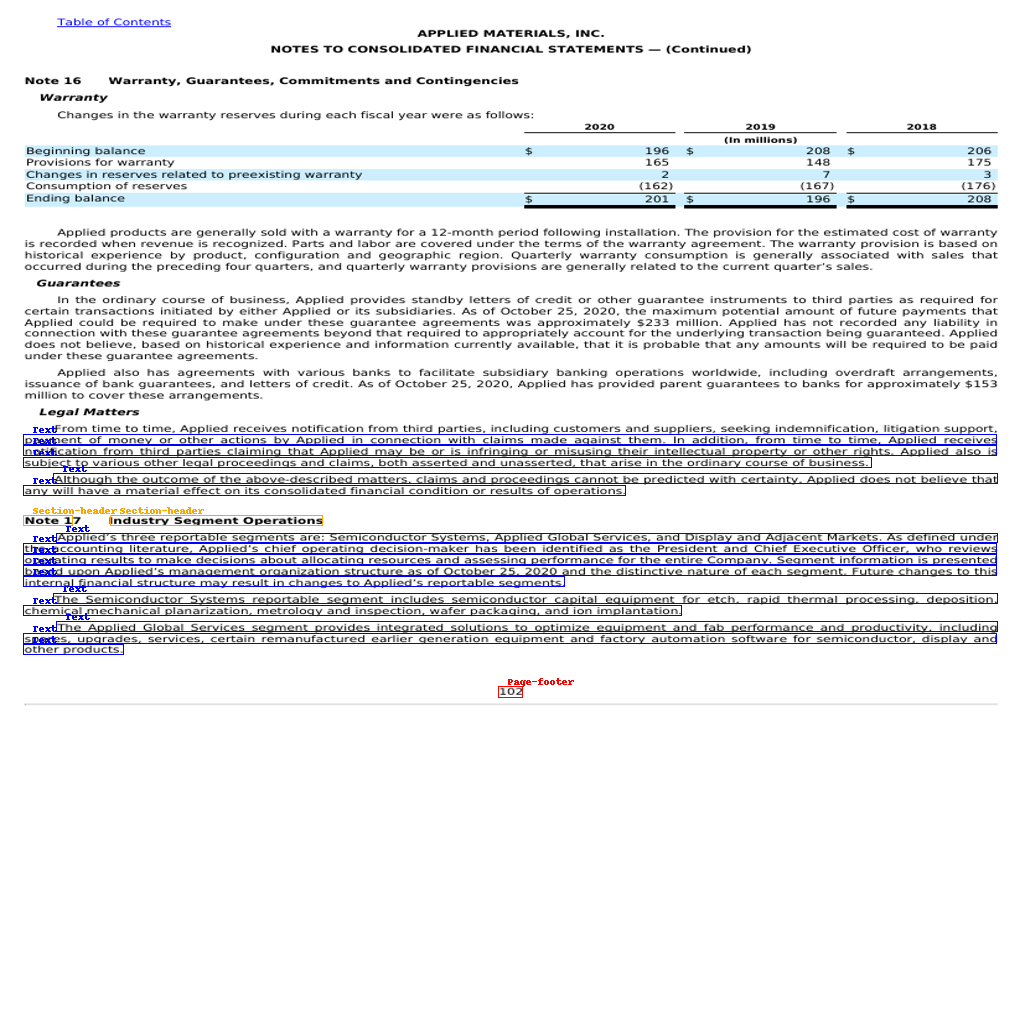


>> Dataframe of annotated lines



,texts,labels,bboxes
0,". In addition, from time to time, Applied rece...",Text,"[23, 434, 996, 444]"
1,notification from third parties claiming that ...,Text,"[23, 445, 996, 455]"
2,subject to various other legal proceedings and...,Text,"[23, 457, 871, 467]"
3,Although the outcome of the above-described ma...,Text,"[53, 473, 997, 483]"
4,any will have a material effect on its consoli...,Text,"[23, 485, 625, 495]"
5,Note 17,Section-header,"[23, 515, 72, 525]"
6,Industry Segment Operations,Section-header,"[110, 515, 322, 525]"
7,Applied’s three reportable segments are: Semic...,Text,"[56, 533, 997, 542]"
8,"the accounting literature, Applied’s chief ope...",Text,"[23, 543, 996, 553]"
9,operating results to make decisions about allo...,Text,"[23, 554, 996, 564]"


In [ ]:
# choose your split
splits = ["all", "train", "validation", "test"]

index_split = 3
split = splits[index_split]

# get and image from random chunk
display_chunk_lines(split=split)

### Create a custom dataset

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # get item
        example = self.dataset[idx]
        encoding = dict()
        # encoding["page_hash"] = example["page_hash"]
        encoding["input_ids"] = example["input_ids"]
        encoding["attention_mask"] = example["attention_mask"]
        encoding["bbox"] = example["normalized_bboxes"]
        encoding["labels"] = example["labels"]
    
        return encoding

In [ ]:
train_dataset = CustomDataset(train_dataset, tokenizer)
eval_dataset = CustomDataset(eval_dataset, tokenizer)
test_dataset = CustomDataset(test_dataset, tokenizer)

In [ ]:
example = train_dataset[0]

for k,v in example.items():
    print(k,len(v))

input_ids 384
attention_mask 384
bbox 384
labels 384


In [ ]:
tokenizer.decode(example["input_ids"])

'<s> Notes to the consolidated financial statements of Aegon N.V. Note 50 270 50 Summary of total financial assets and financial liabilities at fair value through profit or loss The table that follows summarizes the carrying amounts of financial assets and financial liabilities that are classified as at fair value through profit or loss, with appropriate distinction between those financial assets and financial liabilities held for trading and those that, upon initial recognition, were designated as at fair value through profit or loss. 2013 2012 Trading Designated Trading Designated Investments for general account 121 4,712 754 4,809 Investments for account of policyholders - 164,037 - 151,960 Derivatives with positive values not designated as hedges 12,651 - 19,348 - Total financial assets at fair value through profit or loss 12,771 168,749 20,102 156,769 Investment contracts for account of policyholders - 32,628 - 29,188 Derivatives with negative values not designated as hedges 11,24

In [ ]:
# for text, box, label in zip(dataset["train"][0]["texts"], dataset["train"][0]["bboxes_line"], dataset["train"][0]["categories"]):
#     print(text, box, id2label[label])

In [ ]:
len(example["input_ids"])

384

In [ ]:
# for id, box, label in zip(example["input_ids"], example["bbox"], example["labels"]):
#     if label != -100:
#         print(tokenizer.decode([id]), box, id2label[label])
#     else:
#         print(tokenizer.decode([id]), box, -100)

## Define PyTorch DataLoader

In [ ]:
import torch
from torch.utils.data import DataLoader

def collate_fn(features):
    boxes = [feature["bbox"] for feature in features]
    labels = [feature["labels"] for feature in features]
    # use tokenizer to pad input_ids
    batch = tokenizer.pad(features, padding="max_length", max_length=max_length)

    sequence_length = torch.tensor(batch["input_ids"]).shape[1]
    batch["labels"] = [labels_example + [-100] * (sequence_length - len(labels_example)) for labels_example in labels]
    batch["bbox"] = [boxes_example + [[0, 0, 0, 0]] * (sequence_length - len(boxes_example)) for boxes_example in boxes]

    # convert to PyTorch
    # batch = {k: torch.tensor(v, dtype=torch.int64) if isinstance(v[0], list) else v for k, v in batch.items()}
    batch = {k: torch.tensor(v) for k, v in batch.items()}

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
batch = next(iter(train_dataloader))

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
for k,v in batch.items():
    print(k,v.shape)

input_ids torch.Size([8, 384])
attention_mask torch.Size([8, 384])
bbox torch.Size([8, 384, 4])
labels torch.Size([8, 384])


In [ ]:
# for id, box, label in zip(batch["input_ids"][0], batch["bbox"][0], batch["labels"][0]):
#     if label.item() != -100:
#         print(tokenizer.decode([id]), box, id2label[label.item()])
#     else:
#         print(tokenizer.decode([id]), box)

In [ ]:
tokenizer.decode(batch["input_ids"][0])

'<s> personally, as well as to cooperate in measures for the promotion of inland waters fishery implemented by the national or a local government. (財政上の措置等) (Financial Measures) 第七条 国は、内水面漁業の振興に関する施策を実施するために必要な財政上の措置そ の他の措置を講ずるものとする。 Article 7 The national government is to take financial and other measures necessary to take measures for the promotion of inland waters fishery. (連携協力体制の整備) (Development of Coordination and Cooperation System) 第八条 国及び地方公共団体は、内水面漁業の振興に関する施策を効果的に実施するた め、国、関係地方公共団体、海面及び内水面に係る漁業協同組合その他の関係者相互 間の連携協力体制の整備に努めるものとする。 Article 8 In order to effectively implement measures for the promotion of inland waters fishery, the national and local governments are to endeavor to develop systems for coordination and cooperation between the national government, relevant local governments, Fisheries Cooperative Association relating to sea or inland waters, and other persons concerned. 第二章 基本方針等 Chapter II Basic Policy (基本方針) (Basic Policy) 第九条 農林水産大臣は、内水面漁業の振興に関する基本的な方針(以下「基本方針」 と

## Define model

In [ ]:
from transformers import LiltForTokenClassification

model = LiltForTokenClassification.from_pretrained("nielsr/lilt-xlm-roberta-base", 
                                                   id2label=id2label, label2id=label2id, num_labels=num_labels)

Some weights of LiltForTokenClassification were not initialized from the model checkpoint at nielsr/lilt-xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train the model in native PyTorch

Uncomment the code below if you want to train the model just in native PyTorch.

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# optimizer = torch.optim.AdamW(model.parameters(), lr=5-5)

# model.train()
# for epoch in range(2):
#   for batch in train_dataloader:
#       # zero the parameter gradients
#       optimizer.zero_grad()

#       inputs = {k:v.to(device) for k,v in batch.items()}

#       outputs = model(**inputs)

#       loss = outputs.loss
#       loss.backward()

#       optimizer.step()

## Train the model using 🤗 Trainer

We first define a compute_metrics function as well as TrainingArguments.

In [ ]:
import evaluate

# metric = evaluate.load("seqeval")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")

In [ ]:
# source: https://discuss.huggingface.co/t/combining-metrics-for-multiclass-predictions-evaluations/21792/11
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label2id[label_list[p]] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label2id[label_list[l]] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # flat list
    true_predictions = [item for sublist in true_predictions for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    results = {}
    
    results.update(precision_metric.compute(predictions = true_predictions, references = true_labels, average="micro"))
    results.update(recall_metric.compute(predictions = true_predictions, references = true_labels, average="micro"))
    results.update(f1_metric.compute(predictions = true_predictions, references = true_labels, average="micro"))
    results.update(accuracy_metric.compute(predictions = true_predictions, references = true_labels))

    return results

In [ ]:
# delete repo if exists
try:
  from huggingface_hub import HfApi
  HfApi().delete_repo(hub_model_id)
except:
  print("Repository Not Found.")
else:
  print(f"The following repository was deleted: https://huggingface.co/{hub_model_id}")

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir=output_dir, # name of directory to store the checkpoints
                                  hub_model_id=hub_model_id, # name of directory to store the finetuned model in HF hub
                                  num_train_epochs=num_train_epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=per_device_train_batch_size,
                                  per_device_eval_batch_size=per_device_eval_batch_size,
                                  gradient_accumulation_steps=gradient_accumulation_steps,
                                  evaluation_strategy=evaluation_strategy,
                                  eval_steps=eval_steps,
                                  save_steps=save_steps, # eval_steps
                                  save_total_limit=save_total_limit,
                                  load_best_model_at_end=load_best_model_at_end,
                                  metric_for_best_model=metric_for_best_model,
                                  report_to=report_to,
                                  fp16=fp16,
                                  push_to_hub=push_to_hub, # we'd like to push our model to the hub during training
                                  hub_private_repo=hub_private_repo,
                                  hub_strategy=hub_strategy
                                  )

Next we define a custom Trainer which uses the DataLoaders we created above.

In [ ]:
from transformers.data.data_collator import default_data_collator

class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        return train_dataloader

    def get_eval_dataloader(self, eval_dataset = None):
        return eval_dataloader

# Initialize our Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    # callbacks=[ShuffleCallback()] if streaming else None
)

In [ ]:
trainer.train()

In [ ]:
# If occured an erro, train again from a checkpoint
# trainer.train(resume_from_checkpoint="/content/DocLayNet/lilt-xlm-roberta-base-finetuned-DocLayNet-base_lines_ml384-v2/checkpoint-xxxx")

## Push to HF

In [ ]:
trainer.push_to_hub()

# END